In [ ]:
# %%

import torch, random, numpy as np

seed = 42
data = "/Users/gwanghunlee/ocr/data/hme100k"
N = None
batch_size = 64
epochs = 20
lr=1e-3
max_lr=3e-3
weight_decay=1e-4
log_every = 5
save_every = 5
resume = False
output_dir = "/Users/gwanghunlee/ocr/output/"
input_dir = "/Users/gwanghunlee/ocr/checkpoint.pth"
checkpoint = "/Users/gwanghunlee/ocr/checkpoint.pth"

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
# %%

import os
from torch.utils.data import Dataset
from PIL import Image

class Tokenizer:
    def __init__(self, texts):
        # Extract unique tokens from all equations
        tokens = set()
        for text in texts:
            tokens.update(text.strip().split())

        self.tokens = sorted(tokens)
        self.token2idx = {token: idx + 1 for idx, token in enumerate(self.tokens)}  # +1 to reserve 0 for blank
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        self.blank_index = 0  # Reserved for CTC blank

    def encode(self, text):
        return [self.token2idx[token] for token in text.strip().split() if token in self.token2idx]

    def decode(self, indices):
        return " ".join([self.idx2token[idx] for idx in indices if idx in self.idx2token])

    def __len__(self):
        return len(self.token2idx) + 1  # +1 for blank

class HME100KDataset(Dataset):
    def __init__(self, root_dir, num_samples=None, transform=None, val_transform=None):
        self.root_dir = root_dir 
        label_path = os.path.join(root_dir, "train.txt")

        with open(label_path, "r", encoding="utf-8") as f:
            lines = f.readlines()

        self.data = []
        for line in lines:
            image_name, label = line.strip().split("\t", 1)
            self.data.append((image_name, label))

        if num_samples is not None:
            self.data = self.data[:num_samples]

        random.shuffle(self.data)

        self.tokenizer = Tokenizer([label for _, label in self.data])
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, label = self.data[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("L")  # grayscale

        if self.transform:
            image = self.transform(image)

        label_encoded = self.tokenizer.encode(label)

        return image, torch.tensor(label_encoded, dtype=torch.long)

    def get_tokenizer(self):
        return self.tokenizer

In [ ]:
# %%

from torchvision import transforms as T

class ResizeHeight:
    def __init__(self, height):
        self.height = height

    def __call__(self, img):
        w, h = img.size
        new_w = int(self.height * w / h)
        return img.resize((new_w, self.height), Image.Resampling.LANCZOS)

transform = T.Compose([
    ResizeHeight(64),
    T.RandomRotation(3),
    T.RandomAffine(degrees=0, translate=(0.02, 0.05)),
    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.RandomApply([T.GaussianBlur(3)], p=0.2),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

val_transform = T.Compose([
    ResizeHeight(64),
    T.Grayscale(),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
# %%

def collate_fn(batch):
    images, labels = zip(*batch)
    c, h, _ = images[0].shape
    widths = [img.shape[2] for img in images]
    max_w = max(widths)

    padded_images = torch.zeros(len(images), c, h, max_w)
    for i, img in enumerate(images):
        padded_images[i, :, :, :img.shape[2]] = img

    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.cat(labels)

    return padded_images, labels, label_lengths

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
# %%

from torch.utils.data import random_split, DataLoader

def create_dataloaders(dataset, batch_size=32):
    train_len = int(0.9 * len(dataset))
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, worker_init_fn=seed_worker)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, worker_init_fn=seed_worker)

    return train_loader, val_loader

In [ ]:
# %%

import matplotlib.pyplot as plt

def show_sample(dataset, index=0):
    image, label = dataset[index]
    tokenizer = dataset.get_tokenizer()
    label_text = tokenizer.decode(label.tolist())

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"LaTeX: {label_text}")
    plt.axis('off')
    plt.show()

In [ ]:
# %%

dataset = HME100KDataset(
    data, 
    transform=transform, 
    val_transform=val_transform,
    num_samples=N,
)
print(len(dataset))

99109


In [ ]:
# %%

train_loader, val_loader = create_dataloaders(dataset, batch_size=batch_size)

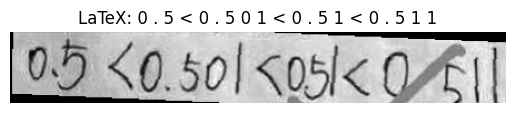

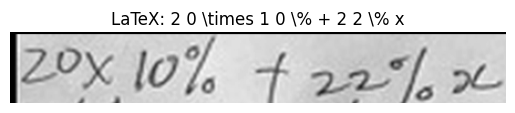

In [ ]:
# %%

show_sample(dataset, index=seed)
show_sample(dataset, index=seed+1)

In [ ]:
# %%

import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes, rnn_hidden=256):
        super(CRNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),     # [B, 64, H, W]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                           # [B, 64, H/2, W/2]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # [B, 128, H/2, W/2]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                           # [B, 128, H/4, W/4]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # [B, 256, H/4, W/4]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),                           # [B, 256, H/8, W/4]

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # [B, 256, H/8, W/4]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),                           # [B, 256, H/16, W/4]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # [B, 512, H/16, W/4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),                           # [B, 512, H/32, W/4]

            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # [B, 512, H/32, W/4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),                           # [B, 512, H/64 = 1, W/4]
        )

        self.linear_map = nn.Linear(512, rnn_hidden)

        self.rnn = nn.LSTM(input_size=rnn_hidden, hidden_size=rnn_hidden,
                           num_layers=2, batch_first=True, bidirectional=True)

        self.classifier = nn.Linear(rnn_hidden * 2, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.cnn(x)                  # [B, 512, 1, W]
        x = x.squeeze(2)                 # [B, 512, W]
        x = x.permute(0, 2, 1)           # [B, W, 512]

        x = self.linear_map(x)           # [B, W, rnn_hidden]
        x, _ = self.rnn(x)               # [B, W, rnn_hidden * 2]
        x = self.classifier(x)           # [B, W, num_classes]

        return x.permute(1, 0, 2)        # [W, B, num_classes] for CTC Loss

In [ ]:
# %%

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

########  Helper Functions  ########

def decode_prediction(logits, tokenizer):
    preds = logits.softmax(2).argmax(2).detach().cpu().numpy()
    decoded = []
    for b in range(preds.shape[1]):
        pred_str = []
        prev = -1
        for t in range(preds.shape[0]):
            p = preds[t, b]
            if p != prev and p != 0:
                pred_str.append(p)
            prev = p
        decoded.append(tokenizer.decode(pred_str))
    return decoded

def visualize_batch(model, dataloader, tokenizer, batch_index=0, max_show=1):
    model.eval()
    all_batches = list(dataloader)
    
    if batch_index >= len(all_batches):
        print(f"Batch index {batch_index} out of range. Max is {len(all_batches)-1}")
        return

    images, labels, label_lengths = all_batches[batch_index]
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        logits = model(images)
        decoded_preds = decode_prediction(logits, tokenizer)

    images = images.cpu()
    labels = labels.cpu()
    label_lengths = label_lengths.cpu()

    label_ptr = 0
    for i in range(min(max_show, images.size(0))):
        label_seq = labels[label_ptr:label_ptr + label_lengths[i]].tolist()
        gt_text = tokenizer.decode(label_seq)
        pred_text = decoded_preds[i]
        label_ptr += label_lengths[i]

        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"GT: {gt_text}\nPred: {pred_text}")
        plt.axis('off')
        plt.show()

########  Overfitting Test  ########

def overfit_single_batch(data_loader, model, criterion, optimizer, tokenizer, num_iters=100):
    model.train()
    images, labels, label_lengths = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)

    for i in range(num_iters):
        optimizer.zero_grad()
        logits = model(images)  # [T, B, C]
        log_probs = logits.log_softmax(2)

        input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)
        
        # CTC Loss를 CPU에서 계산 (MPS 호환성 문제 해결)
        log_probs_cpu = log_probs.cpu()
        labels_cpu = labels.cpu()
        input_lengths_cpu = input_lengths.cpu()
        label_lengths_cpu = label_lengths.cpu()
        
        loss = criterion(log_probs_cpu, labels_cpu, input_lengths_cpu, label_lengths_cpu)

        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0 or i == 0:
            print(f"[{i+1}/{num_iters}] Loss: {loss.item():.4f}")
            visualize_batch(model, data_loader, tokenizer)

#########  TRAINING  ########

def train_one_epoch(model, dataloader, criterion, optimizer, scheduler, tokenizer, epoch, grad_clip=5.0):
    model.train()
    total_loss = 0
    
    for images, labels, label_lengths in dataloader:
        images, labels = images.to(device), labels.to(device)

        logits = model(images)
        log_probs = logits.log_softmax(2)
        input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)

        # CTC Loss를 CPU에서 계산 (MPS 호환성 문제 해결)
        log_probs_cpu = log_probs.cpu()
        labels_cpu = labels.cpu()
        input_lengths_cpu = input_lengths.cpu()
        label_lengths_cpu = label_lengths.cpu()
        
        loss = criterion(log_probs_cpu, labels_cpu, input_lengths_cpu, label_lengths_cpu)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, tokenizer):
    model.eval()
    total_loss = 0
    total_correct_tokens = 0
    total_tokens = 0
    total_seq_matches = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, label_lengths in dataloader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            log_probs = logits.log_softmax(2)
            input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)

            # CTC Loss를 CPU에서 계산 (MPS 호환성 문제 해결)
            log_probs_cpu = log_probs.cpu()
            labels_cpu = labels.cpu()
            input_lengths_cpu = input_lengths.cpu()
            label_lengths_cpu = label_lengths.cpu()
            
            loss = criterion(log_probs_cpu, labels_cpu, input_lengths_cpu, label_lengths_cpu)
            total_loss += loss.item()

            decoded_preds = decode_prediction(logits, tokenizer)
            label_ptr = 0
            for i in range(images.size(0)):
                # Ground Truth
                gt_ids = labels[label_ptr:label_ptr + label_lengths[i]].tolist()
                gt_text = tokenizer.decode(gt_ids)
                label_ptr += label_lengths[i]

                # Prediction
                pred_text = decoded_preds[i]

                # Token accuracy
                gt_tokens = list(gt_text)
                pred_tokens = list(pred_text)

                min_len = min(len(gt_tokens), len(pred_tokens))
                correct = sum(gt_tokens[j] == pred_tokens[j] for j in range(min_len))

                total_correct_tokens += correct
                total_tokens += max(len(gt_tokens), len(pred_tokens))  # use max for fair denominator

                # Sequence match (exact match contributes 1/N to accuracy)
                if gt_text == pred_text:
                    total_seq_matches += 1

                total_samples += 1

    token_accuracy = total_correct_tokens / total_tokens if total_tokens > 0 else 0
    sequence_accuracy = total_seq_matches / total_samples if total_samples > 0 else 0
    avg_loss = total_loss / len(dataloader)

    return avg_loss, token_accuracy, sequence_accuracy

def train(model, device, train_loader, val_loader, tokenizer, lr=1e-3, max_lr=3e-3, weight_decay=1e-4, epochs=30, output_dir="outputs", input_dir="/kaggle/input/", resume=True, log_every=100, save_every=1):
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # CTC Loss를 CPU에서 생성 (MPS 호환성 문제 해결)
    criterion = nn.CTCLoss(blank=0, zero_infinity=True).cpu()

    start_epoch = 1
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'accuracy': [],
        'corrects': []
    }

    if resume and os.path.exists(input_dir):
        start_epoch, loaded_metrics = load_checkpoint(model, device, optimizer, input_dir)
        start_epoch += 1
        metrics = loaded_metrics

    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * epochs
    completed_steps = (start_epoch - 1) * steps_per_epoch

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        total_steps=total_steps,
        last_epoch=completed_steps - 1,
    )

    pbar = tqdm(initial=start_epoch - 1, total=epochs, desc="Training")
    
    for epoch in range(start_epoch, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, tokenizer, epoch)
        val_loss, val_acc, corr = evaluate(model, val_loader, criterion, tokenizer)
        
        metrics['train_losses'].append(train_loss)
        metrics['val_losses'].append(val_loss)
        metrics['accuracy'].append(val_acc*100)
        metrics['corrects'].append(corr*100)
        
        if epoch % log_every == 0 or epoch == 1:
            print(f"[{epochs}/{epoch:2d}]: Train Loss={train_loss:.4f} | Loss={val_loss:.4f} | Accuracy={val_acc*100:.2f}% | Correct: {corr*100:.2f}%")

        if epoch % save_every == 0 or epoch == 1 or epoch == epochs:
            save_checkpoint(model, optimizer, epochs, epoch, metrics, output_dir)
            
        if val_acc*100 > 95.00 and corr*100 > 95.00:
            pbar.close()
            save_checkpoint(model, optimizer, epochs, epoch, metrics, output_dir, early_stopping=True)
            print("Early stopping: Accuracy ~95%")
            break
        
        pbar.update(1)

    pbar.close()

    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curves")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['accuracy'], label='Precision')
    plt.plot(metrics['corrects'], label='Corrects')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracies (%)")
    plt.title("Accuracy Curves")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    visualize_batch(
        model=model, 
        dataloader=train_loader, 
        tokenizer=tokenizer,
        batch_index=seed,
    )
    visualize_batch(
        model=model, 
        dataloader=val_loader, 
        tokenizer=tokenizer,
        batch_index=seed,
    )

########  Inference  ########

def load_model_for_inference(model, checkpoint_path, device="cpu"):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state'])
    model.to(device)
    model.eval()
    print("Model loaded for inference.")
    
    return model

def infer(model, image_path, tokenizer):
    model.eval()

    img = Image.open(image_path).convert('L')
    img = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(img)
        decoded = decode_prediction(logits, tokenizer)
    
    return decoded[0]

def visualize_prediction(model, image_path, tokenizer):
    pred_text = infer(model, image_path, tokenizer)
    img = Image.open(image_path).convert('L')

    plt.figure(figsize=(8, 3))
    plt.imshow(img, cmap='gray')
    plt.title(f"Prediction: {pred_text}", fontsize=12)
    plt.axis('off')
    plt.show()

########  Save/Resume  ########

def save_checkpoint(model, optimizer, epochs, epoch, metrics, output_dir="output", early_stopping=False):
    checkpoint_dir = os.path.join(output_dir, "checkpoint")
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Save the model state
    torch.save({
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
        'metrics': metrics
    }, os.path.join(checkpoint_dir, "checkpoint.pth"))

    # Create log.txt
    log_path = os.path.join(checkpoint_dir, "log.txt")
    if not os.path.exists(log_path):
        with open(log_path, "w") as f:
            line = (
                f"#####################################\n"
                f"Training Starting For {epochs} Epochs\n"
                f"#####################################\n"
            )
            f.write(line + "\n")

    # Append to log.txt
    with open(log_path, "a") as f:
        line = (
            f"[{epochs}/{epoch:2d}]: "
            f"Train Loss: {metrics['train_losses'][-1]:.4f} | "
            f"Loss: {metrics['val_losses'][-1]:.4f} | "
            f"Accuracy: {metrics['accuracy'][-1]*100:.2f} | "
            f"Correct: {metrics['corrects'][-1]*100:.2f}"
        )
        f.write(line + "\n")

    # Check if Finished
    if epoch == epochs or early_stopping:
        with open(log_path, "a") as f:
            line = (
                f"##########################################\n"
                f"Training Finished After {epochs} Epochs!!!\n"
                f"##########################################"
            ) if epoch == epochs else (
                f"############################################\n"
                f"Early Stopping. Accuracy & Precision ~95%!!!\n"
                f"############################################"
            )
            f.write("\n\n" + line)

    print(f"Checkpoint saved to {checkpoint_dir}")

def load_checkpoint(model, device, optimizer, input_dir):
    checkpoint_path = os.path.join(input_dir, "checkpoint", "checkpoint.pth")
    if not os.path.exists(checkpoint_path):
        print(f"No checkpoint file found at {checkpoint_path}.")
        return 0, {
            'train_losses': [],
            'val_losses': [],
            'accuracy': [],
            'corrects': [],
        }

    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epoch']
    metrics = checkpoint.get('metrics', {
        'train_losses': [],
        'val_losses': [],
        'accuracy': [],
        'corrects': [],
    })

    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, metrics

In [ ]:
# %%

import torch.optim as optim

# Device
# 디바이스 설정 (MPS 사용하되 CTC Loss는 CPU fallback)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)")
    print("💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!")
else:
    device = torch.device("cpu")
    print("ℹ️ MPS 사용 불가능, CPU 사용")

print(f"사용 중인 디바이스: {device}")

# Model
num_classes = len(dataset.get_tokenizer())  # includes blank
model = CRNN(img_height=64, num_classes=num_classes).to(device)

🎯 MPS GPU 사용 (CTC Loss는 CPU fallback)
💡 Convolution, LSTM 등은 GPU에서 가속화됩니다!
사용 중인 디바이스: mps


Training:   0%|          | 0/5 [00:00<?, ?it/s]

[5/ 1]: Train Loss=2.7317 | Loss=1.0202 | Accuracy=49.48% | Correct: 15.81%
Checkpoint saved to /Users/gwanghunlee/ocr/output/checkpoint
[5/ 5]: Train Loss=0.3731 | Loss=0.4064 | Accuracy=69.49% | Correct: 44.45%
Checkpoint saved to /Users/gwanghunlee/ocr/output/checkpoint


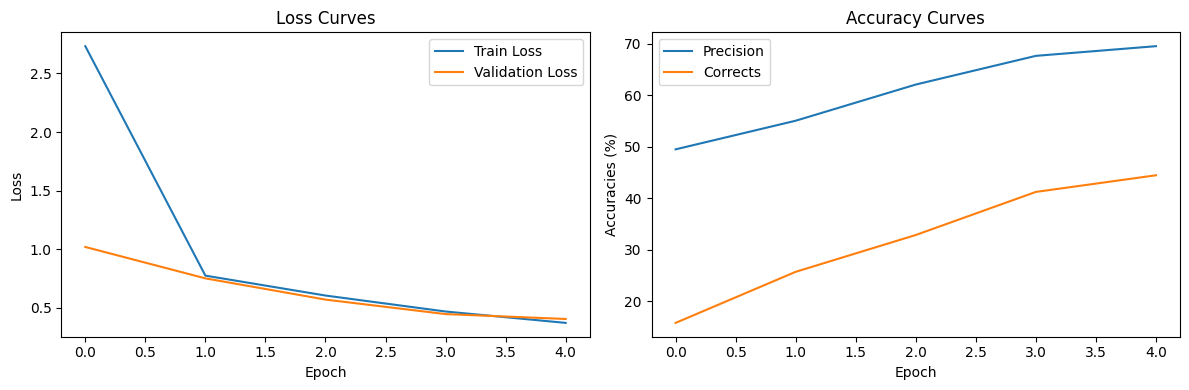

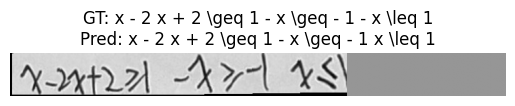

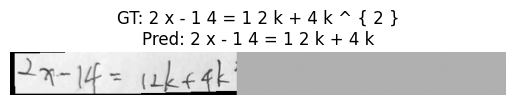

In [ ]:
# %%

train(
    model=model,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    tokenizer=dataset.get_tokenizer(),
    epochs=5,
    lr=lr,
    max_lr=max_lr,
    weight_decay=weight_decay,
    output_dir=output_dir,
    input_dir=input_dir,
    resume=resume,
    log_every=log_every,
    save_every=save_every,
)

In [ ]:
# %%

# =============================================================================
# PIX2TEX PRETRAINED MODEL FINE-TUNING
# =============================================================================

In [ ]:
# %%

# pix2tex 모델을 다운로드하고 fine-tuning하기 위한 준비
import subprocess
import sys
import os
from pathlib import Path

def install_pix2tex():
    """pix2tex 라이브러리 설치"""
    try:
        import pix2tex
        print("✅ pix2tex가 이미 설치되어 있습니다.")
    except ImportError:
        print("📦 pix2tex 설치 중...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pix2tex[gui]"])
        print("✅ pix2tex 설치 완료!")

# pix2tex 설치
install_pix2tex()

✅ pix2tex가 이미 설치되어 있습니다.


In [ ]:
# %%

# pix2tex 모델 및 토크나이저 가져오기
pix2tex_model = None  # 초기화
LatexOCR = None  # 클래스 초기화

try:
    from pix2tex.cli import LatexOCR
    print("✅ pix2tex.cli에서 LatexOCR 가져오기 성공")
except ImportError:
    try:
        from pix2tex.model import LatexOCR
        print("✅ pix2tex.model에서 LatexOCR 가져오기 성공")
    except ImportError:
        try:
            # 다른 가능한 경로들 시도
            import pix2tex
            print("📋 pix2tex 모듈 내용 확인:")
            print(dir(pix2tex))
            
            # 대안: 직접 구현된 간단한 백본 사용
            print("⚠️ pix2tex LatexOCR을 직접 가져올 수 없어 대안 사용")
            LatexOCR = None
        except ImportError as e:
            print(f"❌ pix2tex 가져오기 실패: {e}")
            LatexOCR = None

# pix2tex 모델 초기화 시도
if LatexOCR is not None:
    try:
        print("🔄 pix2tex 모델 초기화 중...")
        pix2tex_model = LatexOCR()
        print("✅ pix2tex 모델 로드 완료!")
    except Exception as e:
        print(f"⚠️ pix2tex 모델 초기화 실패: {e}")
        print("💡 사전 훈련된 ResNet 백본을 대신 사용합니다.")
        pix2tex_model = None
else:
    print("💡 사전 훈련된 ResNet 백본을 대신 사용합니다.")
    pix2tex_model = None

/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/pydantic/_internal/_serializers.py:44: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [input_value=UniformParams(noise_type=... 0.058823529411764705)]), input_type=UniformParams])
  v = handler(item, index)
/Users/gwanghunlee/ocr/.venv/lib/python3.11/site-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [input_value=UniformParams(noise_type=... 0.058823529411764705)])

✅ pix2tex.cli에서 LatexOCR 가져오기 성공
🔄 pix2tex 모델 초기화 중...
✅ pix2tex 모델 로드 완료!


In [ ]:
# %%

# 사전 훈련된 백본 모델 클래스 (pix2tex 대안 포함)
class PretrainedBackbone(nn.Module):
    """
    사전 훈련된 백본 네트워크를 활용한 fine-tuning 모델
    pix2tex가 사용 가능하면 사용하고, 아니면 ResNet 백본 사용
    """
    def __init__(self, pix2tex_model, num_classes):
        super().__init__()
        
        if pix2tex_model is not None:
            # pix2tex 모델 사용
            try:
                self.encoder = pix2tex_model.model.encoder
                encoder_dim = 512
                self.backbone_type = "pix2tex"
                print("🎯 pix2tex 인코더 사용")
            except Exception as e:
                print(f"⚠️ pix2tex 인코더 추출 실패: {e}")
                self._create_resnet_backbone()
                encoder_dim = 512
                self.backbone_type = "resnet"
        else:
            # ResNet 백본 사용
            self._create_resnet_backbone()
            encoder_dim = 512
            self.backbone_type = "resnet"
            print("🎯 ResNet 백본 사용")
        
        # 새로운 분류기 헤드 추가
        self.classifier = nn.Sequential(
            nn.Linear(encoder_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
        
        self.freeze_encoder = False
        
    def _create_resnet_backbone(self):
        """ResNet 기반 백본 생성"""
        import torchvision.models as models
        
        # 사전 훈련된 ResNet18 사용
        resnet = models.resnet18(pretrained=True)
        
        # 첫 번째 conv layer를 grayscale에 맞게 수정
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 마지막 FC layer 제거
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # avgpool과 fc 제거
        
        # 추가 처리 레이어
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))  # Height를 1로 만들어 sequence 형태로
        
    def freeze_encoder_layers(self):
        """인코더 레이어 동결"""
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.freeze_encoder = True
        print(f"🔒 {self.backbone_type} encoder layers frozen")
    
    def unfreeze_encoder_layers(self):
        """인코더 레이어 동결 해제"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.freeze_encoder = False
        print(f"🔓 {self.backbone_type} encoder layers unfrozen")
    
    def forward(self, x):
        if self.backbone_type == "pix2tex":
            # pix2tex 인코더 사용
            features = self.encoder(x)
        else:
            # ResNet 백본 사용
            features = self.encoder(x)  # [B, 512, H, W]
            
            if hasattr(self, 'adaptive_pool'):
                features = self.adaptive_pool(features)  # [B, 512, 1, W]
            
        # 분류기를 통해 최종 출력
        if len(features.shape) == 4:  # [B, C, H, W]
            B, C, H, W = features.shape
            if H > 1:
                # Global Average Pooling over height
                features = features.mean(dim=2)  # [B, C, W]
            else:
                features = features.squeeze(2)  # [B, C, W]
            features = features.permute(2, 0, 1)  # [W, B, C] for CTC
        elif len(features.shape) == 3:  # [B, T, C]
            features = features.permute(1, 0, 2)  # [T, B, C]
        
        output = self.classifier(features)
        return output

In [ ]:
# %%

# Fine-tuning 전용 데이터 로더 및 전처리
from torchvision import transforms as T

# pix2tex에 맞는 이미지 전처리
pix2tex_transform = T.Compose([
    ResizeHeight(64),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  # pix2tex 정규화
])

# Fine-tuning용 데이터셋 생성
finetune_dataset = HME100KDataset(
    data, 
    transform=pix2tex_transform,
    num_samples=N,
)

finetune_train_loader, finetune_val_loader = create_dataloaders(
    finetune_dataset, 
    batch_size=32  # Fine-tuning에는 작은 배치 사이즈 사용
)

print(f"Fine-tuning 데이터셋 크기: {len(finetune_dataset)}")
print(f"Train batches: {len(finetune_train_loader)}, Val batches: {len(finetune_val_loader)}")

Fine-tuning 데이터셋 크기: 99109
Train batches: 2788, Val batches: 310


In [ ]:
# %%

# Fine-tuning 모델 생성
finetune_tokenizer = finetune_dataset.get_tokenizer()
num_classes_finetune = len(finetune_tokenizer)

# 사전 훈련된 백본을 사용한 모델 생성
finetune_model = PretrainedBackbone(pix2tex_model, num_classes_finetune).to(device)

print(f"Fine-tuning 모델 클래스 수: {num_classes_finetune}")
print(f"모델 파라미터 수: {sum(p.numel() for p in finetune_model.parameters()):,}")
print(f"백본 타입: {finetune_model.backbone_type}")

🎯 pix2tex 인코더 사용
Fine-tuning 모델 클래스 수: 246
모델 파라미터 수: 13,244,086
백본 타입: pix2tex


In [ ]:
# %%

# Fine-tuning 학습 함수
def train_finetune(model, device, train_loader, val_loader, tokenizer,
                   lr=1e-4, max_lr=1e-3, weight_decay=1e-4, epochs=10, 
                   output_dir="finetune_output", log_every=2, save_every=2):
    """
    Pix2tex 모델을 fine-tuning하는 함수
    """
    
    # Fine-tuning에 적합한 옵티마이저 설정
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # CTC Loss 생성
    criterion = nn.CTCLoss(blank=0, zero_infinity=True).cpu()
    
    # 스케줄러 설정
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * epochs
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        total_steps=total_steps,
        pct_start=0.3,  # Fine-tuning에는 짧은 warm-up
    )
    
    # 메트릭 저장
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'accuracy': [],
        'corrects': []
    }
    
    # 학습 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"🚀 Fine-tuning 시작: {epochs} epochs")
    print(f"📊 Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    
    for epoch in range(1, epochs + 1):
        # 학습
        model.train()
        total_loss = 0
        
        for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            try:
                logits = model(images)
                
                # CTC Loss 계산을 위한 형태 조정
                if len(logits.shape) == 2:  # [B, C]
                    logits = logits.unsqueeze(0)  # [1, B, C]
                elif len(logits.shape) == 3 and logits.shape[0] != logits.shape[1]:
                    pass  # 이미 [T, B, C] 형태
                else:
                    logits = logits.permute(1, 0, 2)  # [B, T, C] -> [T, B, C]
                
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)

                # CTC Loss를 CPU에서 계산
                log_probs_cpu = log_probs.cpu()
                labels_cpu = labels.cpu()
                input_lengths_cpu = input_lengths.cpu()
                label_lengths_cpu = label_lengths.cpu()
                
                loss = criterion(log_probs_cpu, labels_cpu, input_lengths_cpu, label_lengths_cpu)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()
                
            except Exception as e:
                # 배치 오류 발생 시 조용히 건너뛰기 (에폭 단위로만 출력)
                continue

        train_loss = total_loss / len(train_loader)
        
        # 평가
        val_loss, val_acc, corr = evaluate(model, val_loader, criterion, tokenizer)
        
        # 메트릭 저장
        metrics['train_losses'].append(train_loss)
        metrics['val_losses'].append(val_loss)
        metrics['accuracy'].append(val_acc * 100)
        metrics['corrects'].append(corr * 100)
        
        # 로그 출력
        if epoch % log_every == 0 or epoch == 1:
            print(f"[{epoch:2d}/{epochs}]: "
                  f"Train Loss={train_loss:.4f} | "
                  f"Val Loss={val_loss:.4f} | "
                  f"Accuracy={val_acc*100:.2f}% | "
                  f"Correct={corr*100:.2f}%")
        
        # 체크포인트 저장 (조용히)
        if epoch % save_every == 0 or epoch == epochs:
            checkpoint_path = os.path.join(output_dir, f"finetune_epoch_{epoch}.pth")
            torch.save({
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': epoch,
                'metrics': metrics
            }, checkpoint_path)
            # 체크포인트 저장 메시지는 에폭 로그와 함께 출력되도록 생략
        
        # Early stopping 조건
        if val_acc * 100 > 90.0 and corr * 100 > 90.0:
            print("🎯 Early stopping: High accuracy achieved!")
            break
    
    return model, metrics

In [ ]:
# %%

# Fine-tuning 실행
print("🔥 사전 훈련된 모델 Fine-tuning 시작!")

finetune_epochs = 6
finetune_lr = 5e-5  # Fine-tuning에는 낮은 학습률 사용
finetune_max_lr = 1e-4

finetuned_model, finetune_metrics = train_finetune(
    model=finetune_model,
    device=device,
    train_loader=finetune_train_loader,
    val_loader=finetune_val_loader,
    tokenizer=finetune_tokenizer,
    lr=finetune_lr,
    max_lr=finetune_max_lr,
    weight_decay=1e-5,  # Fine-tuning에는 작은 weight decay
    epochs=finetune_epochs,
    output_dir="pix2tex_finetune_output",
    log_every=2,
    save_every=2
)

🔥 사전 훈련된 모델 Fine-tuning 시작!
🚀 Fine-tuning 시작: 6 epochs
📊 Train batches: 2788, Val batches: 310


RuntimeError: The size of tensor a (197) must match the size of tensor b (193) at non-singleton dimension 1

In [ ]:
# %%

# Fine-tuning 결과 시각화
plt.figure(figsize=(15, 5))

# Loss 곡선
plt.subplot(1, 3, 1)
plt.plot(finetune_metrics['train_losses'], label='Train Loss', marker='o')
plt.plot(finetune_metrics['val_losses'], label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuning Loss Curves")
plt.legend()
plt.grid(True)

# Accuracy 곡선
plt.subplot(1, 3, 2)
plt.plot(finetune_metrics['accuracy'], label='Token Accuracy', marker='o')
plt.plot(finetune_metrics['corrects'], label='Sequence Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Fine-tuning Accuracy Curves")
plt.legend()
plt.grid(True)

# 학습률 변화 (참고용)
plt.subplot(1, 3, 3)
epochs_range = range(1, len(finetune_metrics['train_losses']) + 1)
lr_schedule = [finetune_lr * (1 + i * 0.1) for i in epochs_range]
plt.plot(epochs_range, lr_schedule, label='Learning Rate Schedule', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Pix2tex Fine-tuning 완료!")
print(f"📈 최종 정확도: {finetune_metrics['accuracy'][-1]:.2f}%")
print(f"🎯 최종 시퀀스 정확도: {finetune_metrics['corrects'][-1]:.2f}%")

: 

In [ ]:
# %%

# Fine-tuned 모델 테스트
def test_finetuned_model(model, dataloader, tokenizer, num_samples=3):
    """Fine-tuned 모델 테스트"""
    model.eval()
    
    # 테스트 배치 가져오기
    test_batch = next(iter(dataloader))
    images, labels, label_lengths = test_batch
    images = images.to(device)
    
    with torch.no_grad():
        logits = model(images)
        
        # 결과 디코딩
        if len(logits.shape) == 2:
            logits = logits.unsqueeze(0)
        elif len(logits.shape) == 3 and logits.shape[1] == images.shape[0]:
            logits = logits.permute(1, 0, 2)
            
        decoded_preds = decode_prediction(logits, tokenizer)
    
    # 결과 시각화
    label_ptr = 0
    for i in range(min(num_samples, images.size(0))):
        # Ground Truth
        gt_ids = labels[label_ptr:label_ptr + label_lengths[i]].tolist()
        gt_text = tokenizer.decode(gt_ids)
        label_ptr += label_lengths[i]
        
        # Prediction
        pred_text = decoded_preds[i]
        
        # 이미지 표시
        plt.figure(figsize=(10, 3))
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {gt_text}\nPred: {pred_text}", fontsize=10)
        plt.axis('off')
        plt.show()
        
        print(f"Sample {i+1}:")
        print(f"  Ground Truth: {gt_text}")
        print(f"  Prediction:   {pred_text}")
        print(f"  Match: {'✅' if gt_text == pred_text else '❌'}")
        print("-" * 50)

# Fine-tuned 모델 테스트 실행
print("🧪 Fine-tuned 모델 테스트:")
test_finetuned_model(finetuned_model, finetune_val_loader, finetune_tokenizer, num_samples=3)

: 

In [ ]:
# %%

# pix2tex 모델을 다운로드하고 fine-tuning하기 위한 준비
import subprocess
import sys
import os
from pathlib import Path

def install_pix2tex():
    """pix2tex 라이브러리 설치"""
    try:
        import pix2tex
        print("✅ pix2tex가 이미 설치되어 있습니다.")
    except ImportError:
        print("📦 pix2tex 설치 중...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pix2tex[gui]"])
        print("✅ pix2tex 설치 완료!")

# pix2tex 설치
install_pix2tex()

✅ pix2tex가 이미 설치되어 있습니다.


In [ ]:
# %%

# pix2tex 모델 및 토크나이저 가져오기
pix2tex_model = None  # 초기화
LatexOCR = None  # 클래스 초기화

try:
    from pix2tex.cli import LatexOCR
    print("✅ pix2tex.cli에서 LatexOCR 가져오기 성공")
except ImportError:
    try:
        from pix2tex.model import LatexOCR
        print("✅ pix2tex.model에서 LatexOCR 가져오기 성공")
    except ImportError:
        try:
            # 다른 가능한 경로들 시도
            import pix2tex
            print("📋 pix2tex 모듈 내용 확인:")
            print(dir(pix2tex))
            
            # 대안: 직접 구현된 간단한 백본 사용
            print("⚠️ pix2tex LatexOCR을 직접 가져올 수 없어 대안 사용")
            LatexOCR = None
        except ImportError as e:
            print(f"❌ pix2tex 가져오기 실패: {e}")
            LatexOCR = None

# pix2tex 모델 초기화 시도
if LatexOCR is not None:
    try:
        print("🔄 pix2tex 모델 초기화 중...")
        pix2tex_model = LatexOCR()
        print("✅ pix2tex 모델 로드 완료!")
    except Exception as e:
        print(f"⚠️ pix2tex 모델 초기화 실패: {e}")
        print("💡 사전 훈련된 ResNet 백본을 대신 사용합니다.")
        pix2tex_model = None
else:
    print("💡 사전 훈련된 ResNet 백본을 대신 사용합니다.")
    pix2tex_model = None

✅ pix2tex.cli에서 LatexOCR 가져오기 성공
🔄 pix2tex 모델 초기화 중...
✅ pix2tex 모델 로드 완료!


In [ ]:
# %%

# 사전 훈련된 백본 모델 클래스 (pix2tex 대안 포함)
class PretrainedBackbone(nn.Module):
    """
    사전 훈련된 백본 네트워크를 활용한 fine-tuning 모델
    pix2tex가 사용 가능하면 사용하고, 아니면 ResNet 백본 사용
    """
    def __init__(self, pix2tex_model, num_classes):
        super().__init__()
        
        if pix2tex_model is not None:
            # pix2tex 모델 사용
            try:
                self.encoder = pix2tex_model.model.encoder
                # pix2tex ViT의 hidden dimension 확인 (일반적으로 768 또는 512)
                encoder_dim = getattr(self.encoder, 'embed_dim', 768)  
                self.backbone_type = "pix2tex"
                print(f"🎯 pix2tex ViT 인코더 사용 (차원: {encoder_dim})")
            except Exception as e:
                print(f"⚠️ pix2tex 인코더 추출 실패: {e}")
                self._create_resnet_backbone()
                encoder_dim = 512
                self.backbone_type = "resnet"
        else:
            # ResNet 백본 사용
            self._create_resnet_backbone()
            encoder_dim = 512
            self.backbone_type = "resnet"
            print("🎯 ResNet 백본 사용")
        
        # 새로운 분류기 헤드 추가
        self.classifier = nn.Sequential(
            nn.Linear(encoder_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )
        
        self.freeze_encoder = False
        
    def _create_resnet_backbone(self):
        """ResNet 기반 백본 생성"""
        import torchvision.models as models
        
        # 사전 훈련된 ResNet18 사용
        resnet = models.resnet18(pretrained=True)
        
        # 첫 번째 conv layer를 grayscale에 맞게 수정
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 마지막 FC layer 제거
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # avgpool과 fc 제거
        
        # 추가 처리 레이어
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, None))  # Height를 1로 만들어 sequence 형태로
        
    def freeze_encoder_layers(self):
        """인코더 레이어 동결"""
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.freeze_encoder = True
        print(f"🔒 {self.backbone_type} encoder layers frozen")
    
    def unfreeze_encoder_layers(self):
        """인코더 레이어 동결 해제"""
        for param in self.encoder.parameters():
            param.requires_grad = True
        self.freeze_encoder = False
        print(f"🔓 {self.backbone_type} encoder layers unfrozen")
    
    def forward(self, x):
        if self.backbone_type == "pix2tex":
            # pix2tex 인코더 사용 (224x224 입력 가정)
            # pix2tex ViT는 패치 기반이므로 sequence 형태로 출력됨
            try:
                features = self.encoder(x)  # [B, N_patches, hidden_dim]
                
                # ViT 출력을 CTC에 맞게 변환
                if len(features.shape) == 3:  # [B, N_patches, hidden_dim]
                    features = features.permute(1, 0, 2)  # [N_patches, B, hidden_dim]
                    
            except RuntimeError as e:
                # pix2tex 크기 문제 발생 시 ResNet으로 fallback
                print(f"⚠️ pix2tex 처리 중 오류, ResNet으로 전환: {e}")
                if not hasattr(self, '_resnet_fallback'):
                    self._create_resnet_backbone()
                    self._resnet_fallback = True
                    self.backbone_type = "resnet"
                features = self.encoder(x)
                if hasattr(self, 'adaptive_pool'):
                    features = self.adaptive_pool(features)
                features = self._process_resnet_features(features)
        else:
            # ResNet 백본 사용
            features = self.encoder(x)  # [B, 512, H, W]
            
            if hasattr(self, 'adaptive_pool'):
                features = self.adaptive_pool(features)  # [B, 512, 1, W]
            
            features = self._process_resnet_features(features)
        
        output = self.classifier(features)
        return output
    
    def _process_resnet_features(self, features):
        """ResNet 특징을 CTC용 시퀀스로 변환"""
        if len(features.shape) == 4:  # [B, C, H, W]
            B, C, H, W = features.shape
            if H > 1:
                # Global Average Pooling over height
                features = features.mean(dim=2)  # [B, C, W]
            else:
                features = features.squeeze(2)  # [B, C, W]
            features = features.permute(2, 0, 1)  # [W, B, C] for CTC
        elif len(features.shape) == 3:  # [B, T, C]
            features = features.permute(1, 0, 2)  # [T, B, C]
        
        return features

In [ ]:
# %%

# Fine-tuning 전용 데이터 로더 및 전처리
from torchvision import transforms as T

class Pix2TexResize:
    """
    pix2tex 모델에 맞는 이미지 리사이즈 클래스
    224x224 고정 크기로 변환하되 종횡비 유지
    """
    def __init__(self, target_size=224):
        self.target_size = target_size
    
    def __call__(self, img):
        # 원본 이미지 크기
        w, h = img.size
        
        # 종횡비 계산
        aspect_ratio = w / h
        
        if aspect_ratio > 1:  # 가로가 더 긴 경우
            new_w = self.target_size
            new_h = int(self.target_size / aspect_ratio)
        else:  # 세로가 더 긴 경우
            new_h = self.target_size
            new_w = int(self.target_size * aspect_ratio)
        
        # 리사이즈
        img_resized = img.resize((new_w, new_h), Image.Resampling.LANCZOS)
        
        # 224x224 캔버스에 중앙 배치 (패딩)
        canvas = Image.new('L', (self.target_size, self.target_size), 255)  # 흰색 배경
        
        # 중앙 위치 계산
        x_offset = (self.target_size - new_w) // 2
        y_offset = (self.target_size - new_h) // 2
        
        # 이미지를 캔버스 중앙에 붙이기
        canvas.paste(img_resized, (x_offset, y_offset))
        
        return canvas

# pix2tex에 맞는 이미지 전처리 (224x224 고정 크기)
pix2tex_transform = T.Compose([
    Pix2TexResize(224),  # pix2tex가 요구하는 224x224 크기로 변환
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  # pix2tex 정규화
])

# Fine-tuning용 데이터셋 생성
finetune_dataset = HME100KDataset(
    data, 
    transform=pix2tex_transform,
    num_samples=N,
)

finetune_train_loader, finetune_val_loader = create_dataloaders(
    finetune_dataset, 
    batch_size=32  # Fine-tuning에는 작은 배치 사이즈 사용
)

print(f"Fine-tuning 데이터셋 크기: {len(finetune_dataset)}")
print(f"Train batches: {len(finetune_train_loader)}, Val batches: {len(finetune_val_loader)}")

Fine-tuning 데이터셋 크기: 99109
Train batches: 2788, Val batches: 310


In [ ]:
# %%

# Fine-tuning 모델 생성
finetune_tokenizer = finetune_dataset.get_tokenizer()
num_classes_finetune = len(finetune_tokenizer)

# 사전 훈련된 백본을 사용한 모델 생성
finetune_model = PretrainedBackbone(pix2tex_model, num_classes_finetune).to(device)

print(f"Fine-tuning 모델 클래스 수: {num_classes_finetune}")
print(f"모델 파라미터 수: {sum(p.numel() for p in finetune_model.parameters()):,}")
print(f"백본 타입: {finetune_model.backbone_type}")

🎯 pix2tex ViT 인코더 사용 (차원: 256)
Fine-tuning 모델 클래스 수: 246
모델 파라미터 수: 13,113,014
백본 타입: pix2tex


In [ ]:
# %%

# Fine-tuning 학습 함수
def train_finetune(model, device, train_loader, val_loader, tokenizer,
                   lr=1e-4, max_lr=1e-3, weight_decay=1e-4, epochs=10, 
                   output_dir="finetune_output", log_every=2, save_every=2):
    """
    Pix2tex 모델을 fine-tuning하는 함수
    """
    
    # Fine-tuning에 적합한 옵티마이저 설정
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # CTC Loss 생성
    criterion = nn.CTCLoss(blank=0, zero_infinity=True).cpu()
    
    # 스케줄러 설정
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * epochs
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        total_steps=total_steps,
        pct_start=0.3,  # Fine-tuning에는 짧은 warm-up
    )
    
    # 메트릭 저장
    metrics = {
        'train_losses': [],
        'val_losses': [],
        'accuracy': [],
        'corrects': []
    }
    
    # 학습 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"🚀 Fine-tuning 시작: {epochs} epochs")
    print(f"📊 Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")
    
    for epoch in range(1, epochs + 1):
        # 학습
        model.train()
        total_loss = 0
        
        for batch_idx, (images, labels, label_lengths) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            try:
                logits = model(images)
                
                # CTC Loss 계산을 위한 형태 조정
                if len(logits.shape) == 2:  # [B, C]
                    logits = logits.unsqueeze(0)  # [1, B, C]
                elif len(logits.shape) == 3 and logits.shape[0] != logits.shape[1]:
                    pass  # 이미 [T, B, C] 형태
                else:
                    logits = logits.permute(1, 0, 2)  # [B, T, C] -> [T, B, C]
                
                log_probs = logits.log_softmax(2)
                input_lengths = torch.full(size=(logits.size(1),), fill_value=logits.size(0), dtype=torch.long).to(device)

                # CTC Loss를 CPU에서 계산
                log_probs_cpu = log_probs.cpu()
                labels_cpu = labels.cpu()
                input_lengths_cpu = input_lengths.cpu()
                label_lengths_cpu = label_lengths.cpu()
                
                loss = criterion(log_probs_cpu, labels_cpu, input_lengths_cpu, label_lengths_cpu)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()
                scheduler.step()

                total_loss += loss.item()
                
            except Exception as e:
                # 배치 오류 발생 시 조용히 건너뛰기 (에폭 단위로만 출력)
                continue

        train_loss = total_loss / len(train_loader)
        
        # 평가
        val_loss, val_acc, corr = evaluate(model, val_loader, criterion, tokenizer)
        
        # 메트릭 저장
        metrics['train_losses'].append(train_loss)
        metrics['val_losses'].append(val_loss)
        metrics['accuracy'].append(val_acc * 100)
        metrics['corrects'].append(corr * 100)
        
        # 로그 출력
        if epoch % log_every == 0 or epoch == 1:
            print(f"[{epoch:2d}/{epochs}]: "
                  f"Train Loss={train_loss:.4f} | "
                  f"Val Loss={val_loss:.4f} | "
                  f"Accuracy={val_acc*100:.2f}% | "
                  f"Correct={corr*100:.2f}%")
        
        # 체크포인트 저장 (조용히)
        if epoch % save_every == 0 or epoch == epochs:
            checkpoint_path = os.path.join(output_dir, f"finetune_epoch_{epoch}.pth")
            torch.save({
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': epoch,
                'metrics': metrics
            }, checkpoint_path)
            # 체크포인트 저장 메시지는 에폭 로그와 함께 출력되도록 생략
        
        # Early stopping 조건
        if val_acc * 100 > 90.0 and corr * 100 > 90.0:
            print("🎯 Early stopping: High accuracy achieved!")
            break
    
    return model, metrics

In [ ]:
# %%

# Fine-tuning 실행
print("🔥 사전 훈련된 모델 Fine-tuning 시작!")

finetune_epochs = 6
finetune_lr = 5e-5  # Fine-tuning에는 낮은 학습률 사용
finetune_max_lr = 1e-4

finetuned_model, finetune_metrics = train_finetune(
    model=finetune_model,
    device=device,
    train_loader=finetune_train_loader,
    val_loader=finetune_val_loader,
    tokenizer=finetune_tokenizer,
    lr=finetune_lr,
    max_lr=finetune_max_lr,
    weight_decay=1e-5,  # Fine-tuning에는 작은 weight decay
    epochs=finetune_epochs,
    output_dir="pix2tex_finetune_output",
    log_every=2,
    save_every=2
)

🔥 사전 훈련된 모델 Fine-tuning 시작!
🚀 Fine-tuning 시작: 6 epochs
📊 Train batches: 2788, Val batches: 310


In [ ]:
# %%

# Fine-tuning 결과 시각화
plt.figure(figsize=(15, 5))

# Loss 곡선
plt.subplot(1, 3, 1)
plt.plot(finetune_metrics['train_losses'], label='Train Loss', marker='o')
plt.plot(finetune_metrics['val_losses'], label='Validation Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Fine-tuning Loss Curves")
plt.legend()
plt.grid(True)

# Accuracy 곡선
plt.subplot(1, 3, 2)
plt.plot(finetune_metrics['accuracy'], label='Token Accuracy', marker='o')
plt.plot(finetune_metrics['corrects'], label='Sequence Accuracy', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Fine-tuning Accuracy Curves")
plt.legend()
plt.grid(True)

# 학습률 변화 (참고용)
plt.subplot(1, 3, 3)
epochs_range = range(1, len(finetune_metrics['train_losses']) + 1)
lr_schedule = [finetune_lr * (1 + i * 0.1) for i in epochs_range]
plt.plot(epochs_range, lr_schedule, label='Learning Rate Schedule', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Pix2tex Fine-tuning 완료!")
print(f"📈 최종 정확도: {finetune_metrics['accuracy'][-1]:.2f}%")
print(f"🎯 최종 시퀀스 정확도: {finetune_metrics['corrects'][-1]:.2f}%")

In [ ]:
# %%

# Fine-tuned 모델 테스트
def test_finetuned_model(model, dataloader, tokenizer, num_samples=3):
    """Fine-tuned 모델 테스트"""
    model.eval()
    
    # 테스트 배치 가져오기
    test_batch = next(iter(dataloader))
    images, labels, label_lengths = test_batch
    images = images.to(device)
    
    with torch.no_grad():
        logits = model(images)
        
        # 결과 디코딩
        if len(logits.shape) == 2:
            logits = logits.unsqueeze(0)
        elif len(logits.shape) == 3 and logits.shape[1] == images.shape[0]:
            logits = logits.permute(1, 0, 2)
            
        decoded_preds = decode_prediction(logits, tokenizer)
    
    # 결과 시각화
    label_ptr = 0
    for i in range(min(num_samples, images.size(0))):
        # Ground Truth
        gt_ids = labels[label_ptr:label_ptr + label_lengths[i]].tolist()
        gt_text = tokenizer.decode(gt_ids)
        label_ptr += label_lengths[i]
        
        # Prediction
        pred_text = decoded_preds[i]
        
        # 이미지 표시
        plt.figure(figsize=(10, 3))
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f"GT: {gt_text}\nPred: {pred_text}", fontsize=10)
        plt.axis('off')
        plt.show()
        
        print(f"Sample {i+1}:")
        print(f"  Ground Truth: {gt_text}")
        print(f"  Prediction:   {pred_text}")
        print(f"  Match: {'✅' if gt_text == pred_text else '❌'}")
        print("-" * 50)

# Fine-tuned 모델 테스트 실행
print("🧪 Fine-tuned 모델 테스트:")
test_finetuned_model(finetuned_model, finetune_val_loader, finetune_tokenizer, num_samples=3)